# 2.1.1

## importar librerias y dataset

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## Exploración de datos

In [61]:
df = pd.read_csv("./bank_transactions.csv")

In [62]:
# Elimina filas con al menos un valor nulo
df = df.dropna(axis=0)

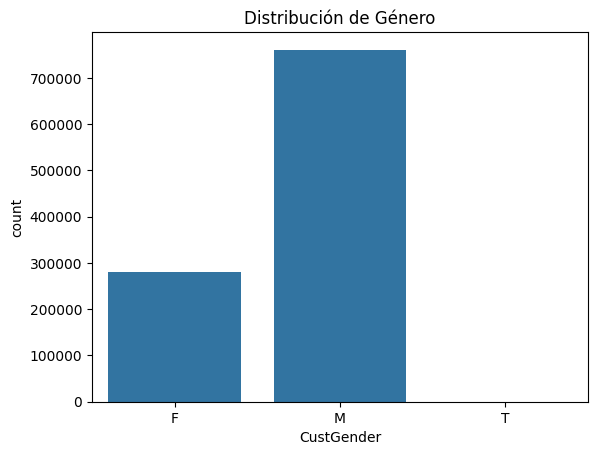

In [63]:
sns.countplot(x=df["CustGender"])
plt.title("Distribución de Género")
plt.show()

In [64]:
df["CustGender"].value_counts()

CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

In [65]:
# Quitar T porque solo tiene un valor y es insignificante
df = df[df["CustGender"] != "T"]

# Balancear el dataset
df_majority = df[df["CustGender"] == "M"]
df_minority = df[df["CustGender"] == "F"]

df_majority_sample = df_majority.sample(n=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_sample, df_minority])


In [66]:
df_balanced["CustGender"].value_counts()

CustGender
M    280635
F    280635
Name: count, dtype: int64

In [67]:
# Calcular la edad
df_balanced["CustomerDOB"] = pd.to_datetime(df_balanced["CustomerDOB"], errors="coerce")
current_year = datetime.now().year
df_balanced["Age"] = current_year - df_balanced["CustomerDOB"].dt.year

C:\Users\Gerax\AppData\Local\Temp\ipykernel_3780\1309165656.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_balanced["CustomerDOB"] = pd.to_datetime(df_balanced["CustomerDOB"], errors="coerce")


In [69]:
nulos = df_balanced.isnull()
print(nulos)

nulos_por_columna = df_balanced.isnull().sum()
print(list(nulos_por_columna))

         TransactionID  CustomerID  CustomerDOB  CustGender  CustLocation  \
483915           False       False        False       False         False   
705277           False       False        False       False         False   
425726           False       False        False       False         False   
445514           False       False        False       False         False   
275975           False       False        False       False         False   
...                ...         ...          ...         ...           ...   
1048549          False       False        False       False         False   
1048552          False       False        False       False         False   
1048556          False       False        False       False         False   
1048557          False       False        False       False         False   
1048558          False       False        False       False         False   

         CustAccountBalance  TransactionDate  TransactionTime  \
483915    

## datos

In [78]:
# Data para usar
df_data = df_balanced[["Age", "CustAccountBalance", "CustGender", "TransactionAmount (INR)"]]
scaler = MinMaxScaler()
df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]] = scaler.fit_transform(df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]])
df_data["CustGender"] = df_data["CustGender"].map({"M": 0, "F": 1})

C:\Users\Gerax\AppData\Local\Temp\ipykernel_3780\2558727267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]] = scaler.fit_transform(df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]])
C:\Users\Gerax\AppData\Local\Temp\ipykernel_3780\2558727267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["CustGender"] = df_data["CustGender"].map({"M": 0, "F": 1})


## Modelo

In [ ]:
class kMeans:
    def __init__(self, k=2, max_iter=100, random_state=42, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
        self.centroids = None

    def fit(self, X):
        np.random.seed(self.random_state)

        # Inicializar centroides aleatorios
        random_indices = np.random.choice(len(X), self.k, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            # Asignar clusters a cada punto
            clusters = self.assign_clusters(X)

            # Calcular nuevos centroides
            new_centroids = np.array([
                # Si no hay puntos asignados a un cluster, no mover el centroide
                X[clusters == i].mean(axis=0) if np.any(clusters == i) else self.centroids[i] 
                for i in range(self.k)
            ])

            # Si los centroides no cambian mucho, detener
            if np.linalg.norm(self.centroids - new_centroids) < self.tol:
                break

            self.centroids = new_centroids

    def assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def predict(self, X):
        return self.assign_clusters(X)


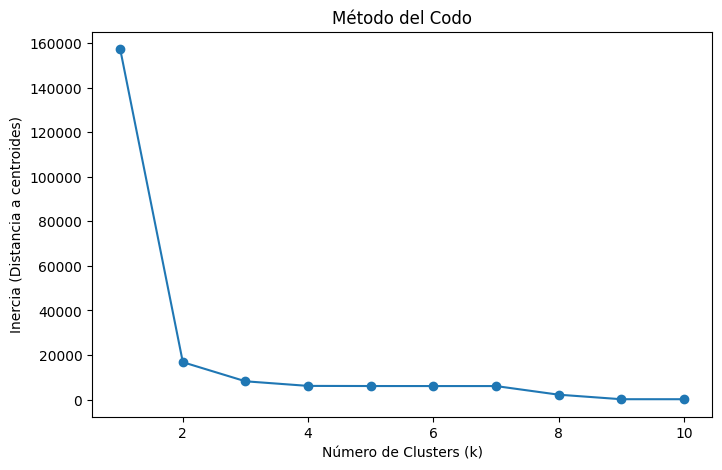

In [ ]:
def elbow_method(X, max_k=10):
    # Graficar el metodo del codo
    inertias = []

    for k in range(1, max_k+1):
        model = kMeans(k=k)
        model.fit(X)
        clusters = model.assign_clusters(X)

        inertia = sum(np.linalg.norm(X[clusters == i] - model.centroids[i])**2 for i in range(k))
        inertias.append(inertia)

    plt.figure(figsize=(8,5))
    plt.plot(range(1, max_k+1), inertias, marker='o', linestyle='-')
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Inercia (Distancia a centroides)")
    plt.title("Método del Codo")
    plt.show()

X = df_data.to_numpy()
elbow_method(X)


In [ ]:
# Aplicar K-Means con k=3
k = 3
model = kMeans(k=k)
X = df_data.to_numpy()

model.fit(X)
clusters = model.assign_clusters(X)  # Obtener asignaciones de cluster
